### Introduction to NEON LiDAR Geotif Rasters

In this lesson, we wil learn how to read in NEON AOP L3 LiDAR Geotiff Rasters (Tiles), and classify a canopy height model based off user-defined thresholds.

Import required packages

In [71]:
import gdal

In [72]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

In [18]:
pwd

'Z:\\NEON_2018\\RSDI-2018\\notebooks\\data\\Day2_LiDAR_Intro'

In [36]:
serc_asp_file = r'Z:\NEON_2018\RSDI-2018\notebooks\data\Day2_LiDAR_Intro\NEON_D17_TEAK_DP3_320000_4100000_aspect.tif'

Open the serc CHM raster with gdal.Open:

In [37]:
serc_asp_dataset = gdal.Open(serc_asp_file)

Read GeoTiff Tags (information about the geotiff raster):
- dimensions (file size)
- number of bands

In [38]:
cols = serc_asp_dataset.RasterXSize
rows = serc_asp_dataset.RasterYSize

print('# of columns:', cols)
print('# of rows:', rows)

# of columns: 1000
# of rows: 1000


In [6]:
print('projection:',serc_asp_dataset.GetProjection())

projection: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


In [39]:
print('geotransform:',serc_asp_dataset.GetGeoTransform())

geotransform: (320000.0, 1.0, 0.0, 4101000.0, 0.0, -1.0)


In [40]:
asp_mapinfo = serc_asp_dataset.GetGeoTransform()
xMin = asp_mapinfo[0]
yMax = asp_mapinfo[3]

xMax = xMin + serc_asp_dataset.RasterXSize/asp_mapinfo[1] #divide by pixel width 
yMin = yMax + serc_asp_dataset.RasterYSize/asp_mapinfo[5] #divide by pixel height (note sign +/-)
serc_asp_ext = (xMin,xMax,yMin,yMax)
print('asp raster extent:',serc_asp_ext)

asp raster extent: (320000.0, 321000.0, 4100000.0, 4101000.0)


In [42]:
serc_asp_raster = serc_asp_dataset.GetRasterBand(1)
noDataVal = serc_asp_raster.GetNoDataValue(); print('no data value:',noDataVal)
scaleFactor = serc_asp_raster.GetScale(); print('scale factor:',scaleFactor)
asp_stats = serc_asp_raster.GetStatistics(True,True)
print('SERC ASP Statistics: Minimum=%.2f, Maximum=%.2f, Mean=%.3f, StDev=%.3f' % 
      (asp_stats[0], asp_stats[1], asp_stats[2], asp_stats[3]))

no data value: -9999.0
scale factor: 1.0
SERC ASP Statistics: Minimum=0.01, Maximum=359.99, Mean=193.353, StDev=88.736


In [43]:
serc_asp_array = serc_asp_dataset.GetRasterBand(1).ReadAsArray(0,0,cols,rows).astype(np.float)
serc_asp_array[serc_asp_array==int(noDataVal)]=np.nan #Assign CHM No Data Values to NaN
serc_asp_array=serc_asp_array/scaleFactor
print('SERC ASP Array:\n',serc_asp_array) #display array values

SERC ASP Array:
 [[163.71200562 160.04100037 159.0019989  ...  18.74500084  19.59300041
   25.36899948]
 [164.477005   161.91799927 160.12800598 ...  17.50900078  22.22900009
   34.88100052]
 [165.58799744 163.79400635 161.91799927 ...  23.70000076  33.625
   49.83300018]
 ...
 [242.97200012 247.46499634 252.26300049 ... 240.147995   249.82499695
  256.61401367]
 [251.91499329 256.54400635 259.59899902 ... 237.49099731 237.39199829
  231.25      ]
 [254.6499939  257.04800415 256.69799805 ... 235.27000427 231.46699524
  224.64500427]]


In [44]:
serc_asp_array.shape

(1000, 1000)

In [46]:
# Calculate the % of pixels that are NaN and non-zero:
pct_nan = np.count_nonzero(np.isnan(serc_asp_array))/(rows*cols)
print('% NaN:',round(pct_nan*100,2))
print('% non-zero:',round(100*np.count_nonzero(serc_asp_array)/(rows*cols),2))

% NaN: 0.0
% non-zero: 100.0


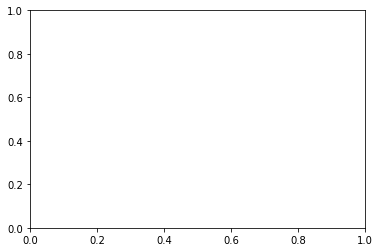

In [49]:
def plot_spatial_array(band_array,spatial_extent,colorlimit,ax=plt.gca(),title='',cmap_title='',colormap=''):
    plot = plt.imshow(band_array,extent=spatial_extent,clim=colorlimit); 
    cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

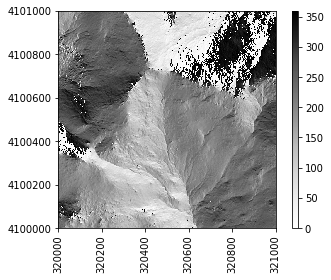

In [50]:
# Use plot_sptatial_array to plot serc chm array

# Input Parameters:
#1. band_array
#2. spatial_exttent,
#3. color limit

#Get the colorlimit extents from teh maximum value from GetRasterSTatsitics (serch_chm_stats) - max is 33
plot_spatial_array(serc_asp_array, serc_asp_ext, (0,360), colormap='Greys')


(0, 15000)

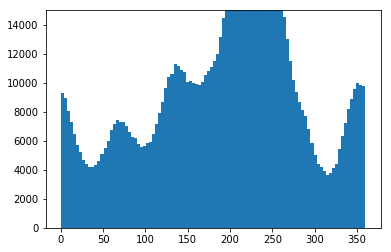

In [51]:
#Make a histogram of the data to see range and distrubtion of values
plt.hist(serc_asp_array[~np.isnan(serc_asp_array)],100);
ax = plt.gca() #define axis handle of current axis
ax.set_ylim([0,15000]) # adjusting the y limit to see the distribution of the non-zero canopy heights

In [52]:
np.ravel(serc_asp_array) #runs quicker, in 2D array

array([163.71200562, 160.04100037, 159.0019989 , ..., 235.27000427,
       231.46699524, 224.64500427])

## Classify CHM Data into different groups of canopy heights

Break (or classify) the CHM array into 10m chunks:


In [53]:
serc_asp_reclass = serc_asp_array.copy() #does the same as copy.copy

In [54]:
serc_asp_reclass

array([[163.71200562, 160.04100037, 159.0019989 , ...,  18.74500084,
         19.59300041,  25.36899948],
       [164.477005  , 161.91799927, 160.12800598, ...,  17.50900078,
         22.22900009,  34.88100052],
       [165.58799744, 163.79400635, 161.91799927, ...,  23.70000076,
         33.625     ,  49.83300018],
       ...,
       [242.97200012, 247.46499634, 252.26300049, ..., 240.147995  ,
        249.82499695, 256.61401367],
       [251.91499329, 256.54400635, 259.59899902, ..., 237.49099731,
        237.39199829, 231.25      ],
       [254.6499939 , 257.04800415, 256.69799805, ..., 235.27000427,
        231.46699524, 224.64500427]])

In [57]:
serc_asp_reclass[np.where((serc_asp_array>0) & (serc_asp_array<=45))] = 1 # North
serc_asp_reclass[np.where((serc_asp_array>45) & (serc_asp_array<135))] = 3 # East
serc_asp_reclass[np.where((serc_asp_array>=135) & (serc_asp_array<=225))] = 2 # South
serc_asp_reclass[np.where((serc_asp_array>225) & (serc_asp_array<315))] = 4 # West
serc_asp_reclass[np.where((serc_asp_array>=315) & (serc_asp_array<=360))] = 1 # North

In [20]:
#display
serc_chm_reclass

array([[3., 3., 3., ..., 1., 1., 1.],
       [3., 3., 3., ..., 1., 1., 1.],
       [3., 3., 2., ..., 1., 1., 1.],
       ...,
       [4., 4., 4., ..., 1., 1., 1.],
       [4., 4., 4., ..., 1., 1., 1.],
       [4., 4., 4., ..., 1., 1., 1.]])

In [58]:
np.amax(serc_asp_reclass)

4.0

In [67]:
#to set your own colormap, use matplotlib.colors
import matplotlib.colors as colors
plt.figure();

#to make a corresponding legend, import matplotlib.patches
import matplotlib.patches as mpatches

<Figure size 432x288 with 0 Axes>

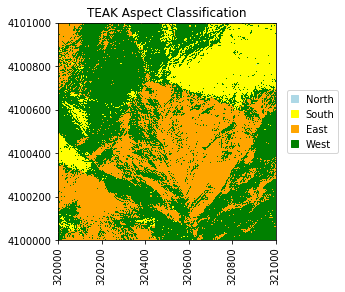

In [77]:
#plot classified chm data with distinct user-defined colors
cmapASP = colors.ListedColormap(['lightblue','yellow','orange','green'])
plt.imshow(serc_asp_reclass,extent=serc_asp_ext,cmap=cmapASP)
plt.title('TEAK Aspect Classification')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

class1_box = mpatches.Patch(color='lightblue', label='North')
class2_box = mpatches.Patch(color='yellow', label='South')
class3_box = mpatches.Patch(color='orange', label='East')
class4_box = mpatches.Patch(color='green', label='West')

ax.legend(handles=[class1_box,class2_box,class3_box,class4_box],
          handlelength=0.7,bbox_to_anchor=(1.05, 0.4),loc='lower left',borderaxespad=0.)

In [63]:
# %load raster2array
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    xMin = mapinfo[0]
    xMax = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    yMin = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    yMax = mapinfo[3]
    
    metadata['extent'] = (xMin,xMax,yMin,yMax)
    
    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()
    
    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
              
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[np.where(array==metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
    
    elif metadata['bands'] > 1:    
        for i in range(1, dataset.RasterCount+1):
            band = float(dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']))
            band[np.where(band==metadata['noDataValue'])]=np.nan
            band = band/metadata['scaleFactor']
            array[...,i-1] = band

    return array, metadata